## Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Naive Python Implementation

### Naive BFS

In [ ]:
def naive_bfs(root,edges,result,max_iter=10):
    result[root]=0
    for i in range(max_iter):
        for k in edges.keys():
            for d in edges[k]:
                if result[k]+1<result[d]:
                    result[d]=result[k]+1

def naive_bfs_path(root,edges,result,max_iter=10):
    result[root]=[]
    for i in range(max_iter):
        for k in edges.keys():
            for d in edges[k]:
                if (len(result[k])+1<len(result[d])) or (len(result[d])==0 and d!=root):
                    result[d]=result[k]+[k]

### Naive Read

In [ ]:
import csv
from collections import defaultdict

def naive_read(fname,w_path=False):
    edges=defaultdict(list)
    result=defaultdict(list) if w_path else defaultdict(float)
    with open(fname, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Discard header line
        for row in reader:
            edges[int(row[0])].append(int(row[1]))
            if not w_path:
                result[int(row[0])]=float('inf')
                result[int(row[1])]=float('inf')
    return edges,result

### Benchmark

In [ ]:
import tracemalloc
import time

tracemalloc.start()
tracemalloc.reset_peak()
py_time_s=time.time()

twitch_data_500_py,result_500_py=naive_read('/content/drive/MyDrive/acad/c631/twitch_subset_500.csv')
naive_bfs(98343,twitch_data_500_py,result_500_py,5)

print(time.time()-py_time_s)
print(tracemalloc.get_traced_memory()[1]/1024/1024)

In [ ]:
tracemalloc.start()
tracemalloc.reset_peak()
py_time_s=time.time()

twitch_data_py,result_py=naive_read('/content/drive/MyDrive/acad/c631/large_twitch_edges.csv')
naive_bfs(98343,twitch_data_py,result_py,5)

print(time.time()-py_time_s)
print(tracemalloc.get_traced_memory()[1]/1024/1024)

In [ ]:
tracemalloc.start()
tracemalloc.reset_peak()
py_time_s=time.time()

twitch_data_500_py,result_500_py=naive_read('/content/drive/MyDrive/acad/c631/twitch_subset_500.csv',w_path=True)
naive_bfs_path(98343,twitch_data_500_py,result_500_py,5)

print(time.time()-py_time_s)
print(tracemalloc.get_traced_memory()[1]/1024/1024)

In [ ]:
tracemalloc.start()
tracemalloc.reset_peak()
py_time_s=time.time()

twitch_data_py,result_py=naive_read('/content/drive/MyDrive/acad/c631/large_twitch_edges.csv',w_path=True)
naive_bfs_path(98343,twitch_data_py,result_py,5)

print(time.time()-py_time_s)
print(tracemalloc.get_traced_memory()[1]/1024/1024)

## Spark Setup

In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar xf spark-3.4.2-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

import findspark
findspark.init()


from pyspark.sql import SparkSession
import random
spark = SparkSession.builder.appName("YourTest")\
.master("local[2]")\
.config('spark.ui.port', random.randrange(4000,5000))\
.config("spark.jars.packages","graphframes:graphframes:0.8.3-spark3.4-s_2.12")\
.getOrCreate()

In [ ]:
from google.colab import output
ui_port=spark.sparkContext.uiWebUrl.split(":")[-1]
output.serve_kernel_port_as_window(ui_port,path='/jobs/index.html')

<IPython.core.display.Javascript object>

In [ ]:
# from pyspark.sql.functions import coalesce, col, lit, sum, when
import pyspark.sql.functions as f
from graphframes import *
from graphframes.lib import Pregel

spark.sparkContext.setCheckpointDir("./checkpoint/")

## BFS

In [ ]:
def bfs(graph, root, max_iter=10):
    g_bfs = graph.pregel \
        .setMaxIter(max_iter) \
        .withVertexColumn("dist",
                          f.when(graph.vertices.id==root,f.lit(0.0))\
                          .otherwise(f.lit(float('inf'))),
                          f.coalesce(Pregel.msg(),\
                                     f.lit(float('inf')))) \
        .sendMsgToDst(f.when(Pregel.src("dist") + 1. < Pregel.dst("dist"),
                             Pregel.src("dist") + 1.)\
                      .otherwise(Pregel.dst("dist")))\
        .aggMsgs(f.min(Pregel.msg()))\
        .run()
    return g_bfs

In [ ]:
def bfs_with_path(graph, root, max_iter=10):
    g_bfs = graph.pregel \
        .setMaxIter(max_iter) \
        .withVertexColumn(
            "path",
            f.when(graph.vertices.id==root,f.array())\
            .otherwise(None),
            f.when(
                Pregel.msg().isNotNull(),
                Pregel.msg()
                ).otherwise(f.col("path"))
            ) \
        .sendMsgToDst(f.when(
            (f.size(Pregel.src("path"))+1<f.size(Pregel.dst("path")))|(Pregel.dst("path").isNull()),
            f.array_append(Pregel.src("path"),Pregel.src("id")))
        )\
        .aggMsgs(f.last(Pregel.msg()))\
        .run()
    return g_bfs

## Implement Proposed Operations

### Degree of Seperation

In [ ]:
def degree_of_seperation(graph, id_from, id_to, max_iter=10):
    bfs=bfs(graph, id_from, max_iter=max_iter)
    return bfs.filter(bfs.id==id_to).collect()[0].asDict()

### Degree of Seperation (single user)

In [ ]:
def degree_of_seperation_single(graph, id, max_iter=10):
    bfs=bfs(graph, id, max_iter=max_iter)
    return bfs

### Shortest Path from Single Source

In [ ]:
def sssp(graph, id, max_iter=10):
    bfs=bfs_with_path(graph, id, max_iter=max_iter)
    return bfs

## Simple Graph Test

In [ ]:
edges = spark.createDataFrame([
    [0, 1],
    [1, 2],
    [2, 4],
    [2, 0],
    [3, 4],
    [4, 0],
    [4, 2],
    [0, 4],
    [2, 5]
    ], ["src", "dst"])

edges.cache()
vertices = spark.createDataFrame([[0], [1], [2], [3], [4], [5]], ["id"])
vertices.show()

vertices.cache()
graph = GraphFrame(vertices, edges)

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
+---+

+---+--------+
| id|    dist|
+---+--------+
|  0|     0.0|
|  5|     3.0|
|  1|     1.0|
|  3|Infinity|
|  2|     2.0|
|  4|     1.0|
+---+--------+

+---+---------+
| id|     path|
+---+---------+
|  0|       []|
|  5|[0, 4, 2]|
|  1|      [0]|
|  3|     null|
|  2|   [0, 4]|
|  4|      [0]|
+---+---------+



In [ ]:
t1=degree_of_seperation(graph,0,max_iter=5)
t1.show()

In [ ]:
t1p=sssp(graph,0,max_iter=5)
t1p.show()

## `twitch_gamers` Test (Reduced)

In [ ]:
# Read the excel file / rename columns
twitch_gamers = spark.read.format("csv").option("header", "true").load(
    "/content/drive/MyDrive/acad/c631/twitch_subset_500.csv").withColumnRenamed("numeric_id_1",
                                                                                          "src").withColumnRenamed(
    "numeric_id_2", "dst")

vertices2 = twitch_gamers.select("src").union(twitch_gamers.select("dst")).distinct().withColumnRenamed("src", "id")
vertices2.cache()

edges2 = twitch_gamers.select("src", "dst")
edges2.cache()

graph2 = GraphFrame(vertices2, edges2)

# Show graph
graph2.vertices.show()
graph2.edges.show()

+------+
|    id|
+------+
|113417|
|103123|
|131033|
|138305|
|101021|
| 27248|
|  8433|
| 70078|
| 34043|
|124065|
|129564|
|155216|
| 48184|
| 12508|
|  1956|
|  6212|
|   700|
| 30520|
| 58134|
| 92439|
+------+
only showing top 20 rows

+-----+------+
|  src|   dst|
+-----+------+
|98343|141493|
|98343| 58736|
|98343|140703|
|98343|151401|
|98343|157118|
|98343|125430|
|98343|  3635|
|98343|   495|
|98343|116648|
|98343|  1679|
|98343|123861|
|98343| 89631|
|98343|113417|
|98343|145281|
|98343| 10408|
|98343|  3181|
|98343| 40675|
|98343| 95914|
|98343|155127|
|98343|124827|
+-----+------+
only showing top 20 rows



In [ ]:
t2=degree_of_seperation(graph2,98343,max_iter=5)
t2.show()

+------+----+
|    id|dist|
+------+----+
|101021| 2.0|
|103123| 2.0|
|113417| 1.0|
|131033| 2.0|
|138305| 2.0|
| 27248| 2.0|
| 70078| 2.0|
|  8433| 2.0|
|124065| 2.0|
|129564| 2.0|
| 34043| 2.0|
|155216| 2.0|
| 48184| 2.0|
| 12508| 2.0|
|  1956| 2.0|
|  6212| 2.0|
|   700| 2.0|
| 30520| 1.0|
| 58134| 2.0|
| 92439| 2.0|
+------+----+
only showing top 20 rows



In [ ]:
t2p=sssp(graph2,98343,max_iter=5)
t2p.show()

+------+---------------+
|    id|           path|
+------+---------------+
|101021|[98343, 141493]|
|103123|[98343, 141493]|
|113417|        [98343]|
|131033|[98343, 141493]|
|138305|[98343, 141493]|
| 27248|[98343, 141493]|
| 70078|[98343, 141493]|
|  8433|[98343, 141493]|
|124065|[98343, 141493]|
|129564|[98343, 141493]|
| 34043|[98343, 141493]|
|155216|[98343, 141493]|
| 48184|[98343, 141493]|
| 12508|[98343, 141493]|
|  1956|[98343, 141493]|
|  6212|[98343, 141493]|
|   700|[98343, 141493]|
| 30520|        [98343]|
| 58134|[98343, 141493]|
| 92439|[98343, 141493]|
+------+---------------+
only showing top 20 rows



## `twitch_gamers` Test (Full)

In [ ]:
# Read the excel file / rename columns
twitch_gamers_full = spark.read.format("csv").option("header", "true").load(
    "/content/drive/MyDrive/acad/c631/large_twitch_edges.csv").withColumnRenamed("numeric_id_1",
                                                                                          "src").withColumnRenamed(
    "numeric_id_2", "dst")

vertices3 = twitch_gamers_full.select("src").union(twitch_gamers_full.select("dst")).distinct().withColumnRenamed("src", "id")
vertices3.cache()

edges3 = twitch_gamers_full.select("src", "dst")
edges3.cache()

graph3 = GraphFrame(vertices3, edges3)

# Show graph
graph3.vertices.show()
graph3.edges.show()

+------+
|    id|
+------+
|113417|
|128181|
| 13772|
| 42688|
|106585|
|140876|
| 46683|
| 17427|
|102521|
|  2162|
| 29454|
| 82197|
|131033|
|154118|
|147244|
| 90391|
|149687|
| 76686|
| 57569|
| 80258|
+------+
only showing top 20 rows

+-----+------+
|  src|   dst|
+-----+------+
|98343|141493|
|98343| 58736|
|98343|140703|
|98343|151401|
|98343|157118|
|98343|125430|
|98343|  3635|
|98343|   495|
|98343|116648|
|98343|  1679|
|98343|123861|
|98343| 89631|
|98343|113417|
|98343|145281|
|98343| 10408|
|98343|  3181|
|98343| 40675|
|98343| 95914|
|98343|155127|
|98343|124827|
+-----+------+
only showing top 20 rows



In [ ]:
t3=bfs(graph3,98343,max_iter=6)
t3.show()

+------+----+
|    id|dist|
+------+----+
|100010| 3.0|
|100140| 3.0|
|100227| 2.0|
|100263| 2.0|
|100320| 3.0|
|100553| 3.0|
|100704| 2.0|
|100735| 3.0|
|100768| 3.0|
| 10096| 3.0|
|100964| 3.0|
|101021| 2.0|
|101122| 2.0|
|101205| 3.0|
|101261| 3.0|
|101272| 3.0|
|102113| 3.0|
|102521| 2.0|
|102536| 3.0|
|102539| 3.0|
+------+----+
only showing top 20 rows



In [ ]:
t3p=sssp(graph3,98343,max_iter=5)
t3p.show()

In [ ]:
reachable=t3.where(t3.dist<float("inf"))

In [ ]:
t3.where(t3.dist==1.).select(f.count(t3.dist)).show()

+-----------+
|count(dist)|
+-----------+
|         39|
+-----------+



In [ ]:
t3.select(f.count(t3.dist)).show()

+-----------+
|count(dist)|
+-----------+
|     168114|
+-----------+



In [ ]:
reachable.select(f.count(t3.dist)).show()

+-----------+
|count(dist)|
+-----------+
|     167894|
+-----------+



In [ ]:
reachable.select(f.max(t3.dist)).show()

+---------+
|max(dist)|
+---------+
|      5.0|
+---------+



In [ ]:
reachable.select(f.avg(t3.dist)).show()

+-----------------+
|        avg(dist)|
+-----------------+
|2.802792237959665|
+-----------------+



In [ ]:
reachable.select(f.median(t3.dist)).show()

+------------+
|median(dist)|
+------------+
|         3.0|
+------------+



In [ ]:
!pip install -q pyspark_dist_explore

(array([0.00000e+00, 3.90000e+01, 4.13320e+04, 1.59752e+05, 1.67894e+05]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

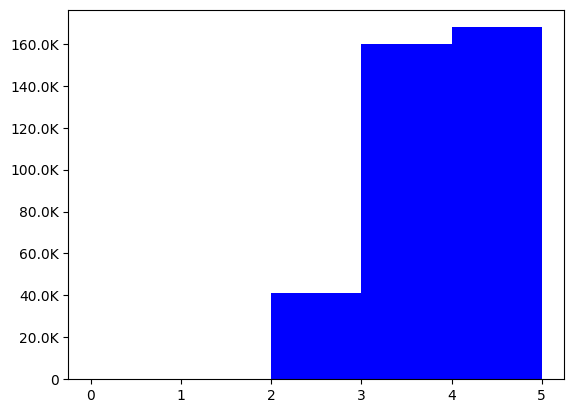

In [ ]:
from pyspark_dist_explore import hist, Histogram
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, t3.select('dist'), bins = [0,1,2,3,4,5], color=['blue'])

In [ ]:
fig, ax = plt.subplots()
hist(ax, t3.select('dist'), bins = [0,1,2,3,4,5], color=['blue'])